In [1]:
%matplotlib inline
import os
import torch
import torchvision
from d2l import torch as d2l

In [2]:
d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
                          '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')

voc_dir = d2l.download_extract('voc2012','VOCdevkit/VOC2012')

In [3]:
print(voc_dir)
def read_voc_images(voc_dir,is_train=True):
    "读取所有的voc图像并标注"
    txt_fname=os.path.join(voc_dir,'ImageSets','Segmentation','train.txt' if is_train else 'val.txt')
    mode=torchvision.io.image.ImageReadMode.RGB
    #使用这个模式时，图像会以 RGB 格式加载，也就是说图像会被读取为一个包含红、绿、蓝三个通道的 3 通道图像。
    with open(txt_fname,'r') as f:
        images=f.read().split()
    features,labels=[],[]
    for i,fname in enumerate(images):
        features.append(torchvision.io.read_image(os.path.join(voc_dir,'JPEGImages',f'{fname}.jpg')))
        labels.append(torchvision.io.read_image(os.path.join(voc_dir,'SegmentationClass',f'{fname}.png'),mode))
    return features,labels
train_features,train_labels=read_voc_images(voc_dir,True)

..\data\VOCdevkit/VOC2012


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

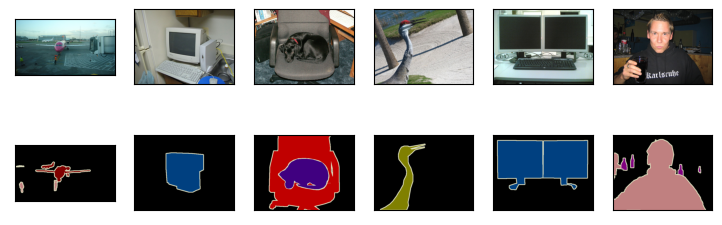

In [4]:
n=6
imgs=train_features[:n]+train_labels[:n]
imgs=[img.permute(1,2,0) for img in imgs]
d2l.show_images(imgs,2,n)

In [5]:
# 列举RGB颜色值和类名
# 每一种RGB颜色对应的标号
# 定义VOC_COLORMAP，这是一个列表，包含了PASCAL VOC数据集中每种类别的RGB颜色值。每种类别在标签图像中由一种特定的颜色表示，颜色的RGB值就是这里定义的。
VOC_COLORMAP = [[0,0,0],[128,0,0],[0,128,0],[128,128,0],
               [0,0,128],[128,0,128],[0,128,128],[128,128,128],
               [64,0,0],[192,0,0],[64,128,0],[192,128,0],
               [64,0,128],[192,0,128],[64,128,128],[192,128,128],
               [0,64,0],[128,64,0],[0,192,0],[128,192,0],
               [0,64,128]]

# 定义VOC_CLASSES，这是一个列表，包含了PASCAL VOC数据集中每种类别的名字。列表中的类别名顺序与VOC_COLORMAP中的颜色值顺序相对应。
VOC_CLASSES = ['background','aeroplane','bicycle','bird','boat','bottle','bus',
              'car','cat','chair','cow','diningtable','dog','horse','motorbike',
              'person','potted plant','sheep','sofa','train','tv/monitor']   

In [6]:
#查找标签中每个像素的类索引
def voc_colormap2label():
    colormap2label=torch.zeros(256**3,dtype=torch.long)
    for i,colormap in enumerate(VOC_COLORMAP):
        colormap2label[(colormap[0]*256+colormap[1])*256+colormap[2]]=i
    return colormap2label
def voc_label_indices(colormap,colormap2label):
    colormap=colormap.permute(1,2,0).numpy().astype('int32')
    idx=((colormap[:,:,0]*256+colormap[:,:,1])*256+colormap[:,:,2])
    return colormap2label[idx]

In [7]:
y=voc_label_indices(train_labels[0],voc_colormap2label())
print(train_labels[0].shape)
print(y[105:115,130:140])
print(VOC_CLASSES[1])

torch.Size([3, 281, 500])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]])
aeroplane


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

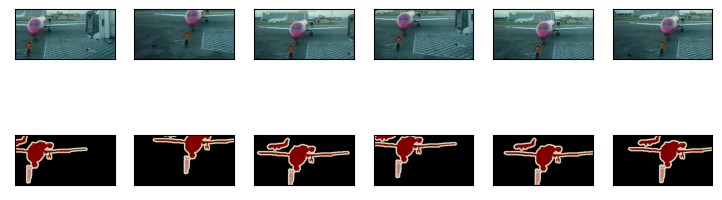

In [8]:
#使用图片增广进行随机剪裁
def voc_rand_crop(feature,label,height,width):
    rect=torchvision.transforms.RandomCrop.get_params(feature,(height,width))
    feature=torchvision.transforms.functional.crop(feature,*rect)
    label=torchvision.transforms.functional.crop(label,*rect)
    return feature,label
imgs=[]
for _ in range(n):
    imgs+=voc_rand_crop(train_features[0],train_labels[0],height=150,width=300)
imgs=[img.permute(1,2,0) for img in imgs]
d2l.show_images(imgs[::2]+imgs[1::2],2,n)

In [9]:
class VOCSegDataset(torch.utils.data.Dataset):
    def __init__(self,is_train,crop_size,voc_dir):
        self.transform=torchvision.transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
        self.crop_size=crop_size
        features,labels=read_voc_images(voc_dir,is_train=is_train)
        self.features=[self.normalize_image(feature) for feature in self.filter(features)]
        self.labels=self.filter(labels)
        self.colormap2label=voc_colormap2label()
        print('read '+str(len(self.features))+' examples')
    def normalize_image(self,img):
        return self.transform(img.float())
    def filter(self,imgs):
        return [img for img in imgs if(img.shape[1]>=self.crop_size[0] and img.shape[2]>=self.crop_size[1])]
    def __getitem__(self,idx):
        feature,label=voc_rand_crop(self.features[idx],self.labels[idx]
                                    ,*self.crop_size)
        return (feature,voc_label_indices(label,self.colormap2label))
    def __len__(self):
        return len(self.features)

In [10]:
crop_size=(320,480)
voc_train=VOCSegDataset(True,crop_size,voc_dir)
voc_test=VOCSegDataset(False,crop_size,voc_dir)

read 1114 examples
read 1078 examples


In [11]:
batch_size=64
train_iter=torch.utils.data.DataLoader(voc_train,batch_size,shuffle=True,drop_last=True)
#drop_last=True 的作用是：当数据集的大小不能被批次大小整除时，丢弃最后一个不足批次大小的数据。
for X,Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

torch.Size([64, 3, 320, 480])
torch.Size([64, 320, 480])


In [12]:
#整合所有组件
# 整合所有组件
# 定义一个函数来加载VOC语义分割数据集，输入参数是批次大小和裁剪尺寸
def load_data_voc(batch_size, crop_size):
    """加载VOC语义分割数据集"""
    # 下载并提取VOC2012数据集，获取数据集的路径
    voc_dir = d2l.download_extract('voc2012',os.path.join('VOCdevkit','VOC2012'))  
    # 获取数据加载器的工作进程数量
    num_workers = d2l.get_dataloader_workers()
    # 创建一个训练数据加载器实例，输入参数分别为：VOCSegDataset是待加载的数据集，batch_size是批次大小，shuffle=True表示在每个迭代周期中随机打乱数据，drop_last=True表示如果最后一个批次的样本数量小于batch_size，则丢弃该批次，num_workers是数据加载器的工作进程数量
    train_iter = torch.utils.data.DataLoader(VOCSegDataset(True, crop_size, voc_dir), batch_size,shuffle=True,
                                            drop_last = True, num_workers=num_workers)
    # 创建一个测试数据加载器实例，输入参数分别为：VOCSegDataset是待加载的数据集，batch_size是批次大小，drop_last=True表示如果最后一个批次的样本数量小于batch_size，则丢弃该批次，num_workers是数据加载器的工作进程数量
    test_iter = torch.utils.data.DataLoader(VOCSegDataset(False, crop_size, voce_dir), batch_size, drop_last=True,
                                           num_workers=num_workers)
    # 返回训练数据加载器和测试数据加载器
    return train_iter, test_iter